In [26]:
# Library
import kagglehub
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix


In [27]:
path = kagglehub.dataset_download("tolgadincer/labeled-chest-xray-images")
print("Dataset downloaded to:", path)

Using Colab cache for faster access to the 'labeled-chest-xray-images' dataset.
Dataset downloaded to: /kaggle/input/labeled-chest-xray-images


Total images: 5856
Class counts:
 class
PNEUMONIA    4273
NORMAL       1583

Counts by split:
 class  NORMAL  PNEUMONIA
split                   
test      234        390
train    1349       3883


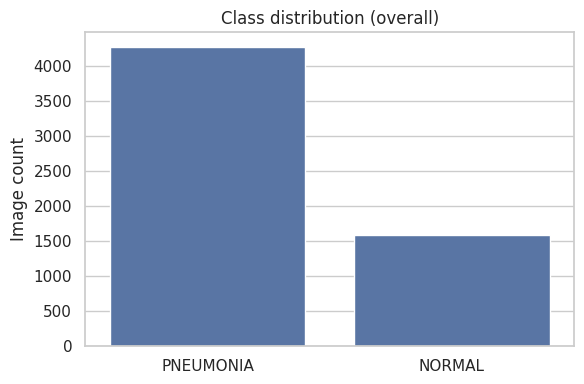

<Figure size 700x400 with 0 Axes>

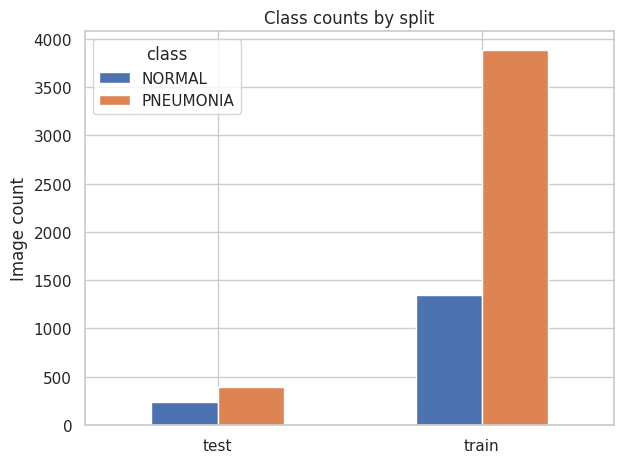

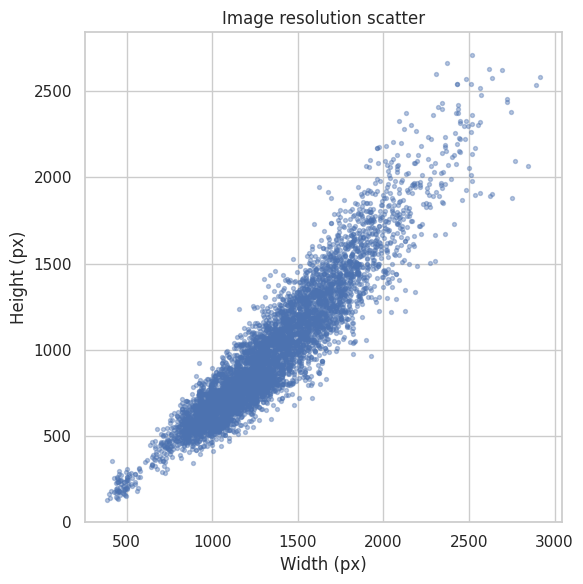

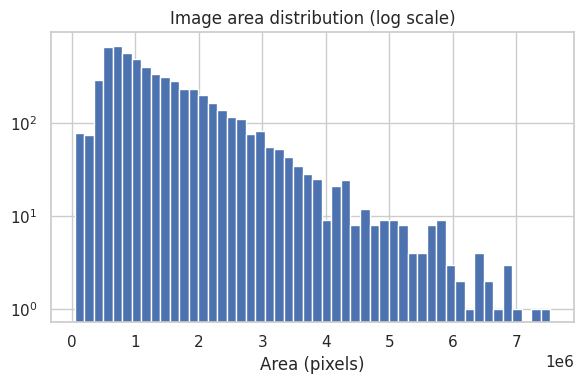

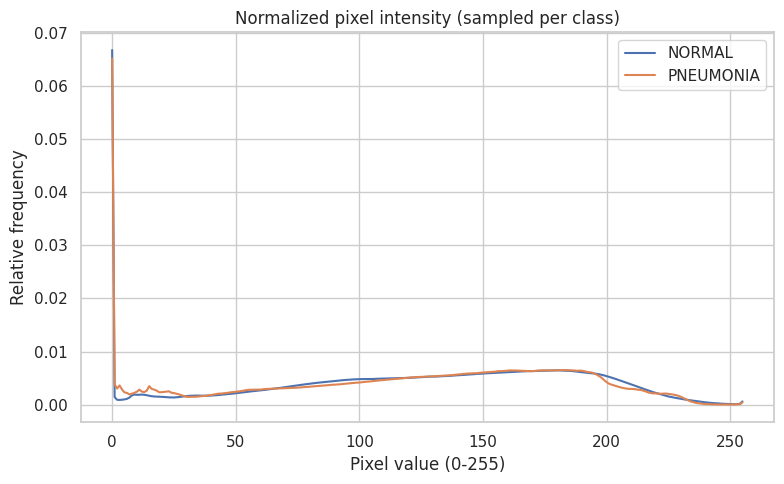

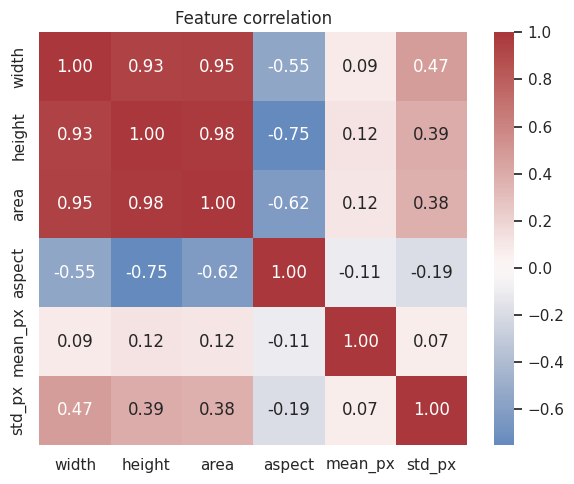

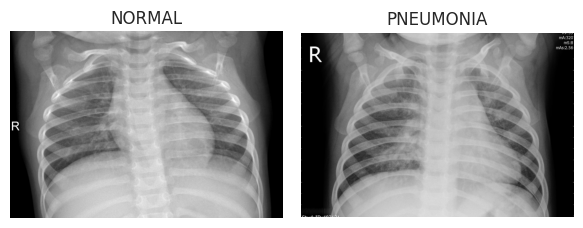

Exploration artifacts saved in: exploration_outputs
Check per_class_summary.csv and image_metadata.csv for exact numeric values to cite in your write-up.


In [28]:
# Data Exploration

sns.set(style="whitegrid")
base_dir = os.path.join(path, "chest_xray")  # adjust if different
splits = ["train", "test"]
out_dir = "exploration_outputs"
os.makedirs(out_dir, exist_ok=True)

# --- gather basic metadata (fast, non-recursive per expected layout) ---
rows = []
for split in splits:
    split_dir = os.path.join(base_dir, split)
    if not os.path.isdir(split_dir):
        continue
    for cls in sorted(os.listdir(split_dir)):
        cls_dir = os.path.join(split_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        for fname in os.listdir(cls_dir):
            fpath = os.path.join(cls_dir, fname)
            try:
                with Image.open(fpath) as im:
                    im_g = im.convert("L")
                    w, h = im_g.size
                    arr = np.asarray(im_g)
                    rows.append({
                        "split": split,
                        "class": cls,
                        "filename": fname,
                        "width": int(w),
                        "height": int(h),
                        "area": int(w*h),
                        "aspect": float(w)/float(h),
                        "mean_px": float(arr.mean()),
                        "std_px": float(arr.std())
                    })
            except Exception:
                rows.append({
                    "split": split,
                    "class": cls,
                    "filename": fname,
                    "width": np.nan,
                    "height": np.nan,
                    "area": np.nan,
                    "aspect": np.nan,
                    "mean_px": np.nan,
                    "std_px": np.nan
                })

df = pd.DataFrame(rows)
df.to_csv(os.path.join(out_dir, "image_metadata.csv"), index=False)

# --- summary stats (printable & saved) ---
total_images = len(df)
class_counts = df['class'].value_counts(dropna=True)
split_counts = df.groupby(['split','class']).size().unstack(fill_value=0)
per_class_summary = df.groupby('class')[['width','height','area','mean_px','std_px']].agg(['count','mean','median','std']).round(2)
per_class_summary.to_csv(os.path.join(out_dir, "per_class_summary.csv"))

print(f"Total images: {total_images}")
print("Class counts:\n", class_counts.to_string())
print("\nCounts by split:\n", split_counts)

# --- VISUALIZATIONS ---

# 1) Class distribution (overall)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="class", order=class_counts.index)
plt.title("Class distribution (overall)")
plt.ylabel("Image count")
plt.xlabel("")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "class_distribution.png"), dpi=150)
plt.show(); plt.close()

# 2) Class counts by split
plt.figure(figsize=(7,4))
split_counts.plot(kind='bar', rot=0)
plt.title("Class counts by split")
plt.ylabel("Image count")
plt.xlabel("")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "class_counts_by_split.png"), dpi=150)
plt.show(); plt.close()

# 3) Resolution scatter (width vs height)
plt.figure(figsize=(6,6))
plt.scatter(df['width'].dropna(), df['height'].dropna(), s=8, alpha=0.4)
plt.xlabel("Width (px)"); plt.ylabel("Height (px)")
plt.title("Image resolution scatter")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "resolution_scatter.png"), dpi=150)
plt.show(); plt.close()

# 4) Area distribution (log scale)
plt.figure(figsize=(6,4))
plt.hist(df['area'].dropna(), bins=50, log=True)
plt.title("Image area distribution (log scale)")
plt.xlabel("Area (pixels)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "area_distribution.png"), dpi=150)
plt.show(); plt.close()

# 5) Pixel intensity histograms per class (sampled for speed)
SAMPLE_PER_CLASS = 60
plt.figure(figsize=(8,5))
for cls in sorted(df['class'].dropna().unique()):
    sample_paths = df[df['class']==cls].dropna(subset=['filename']).head(SAMPLE_PER_CLASS)
    hist_accum = np.zeros(256, dtype=np.float64)
    total_pixels = 0
    for _, r in sample_paths.iterrows():
        p = os.path.join(base_dir, r['split'], r['class'], r['filename'])
        try:
            with Image.open(p) as im:
                a = np.asarray(im.convert("L")).ravel()
                hist_accum[:len(np.bincount(a))] += np.bincount(a, minlength=256)
                total_pixels += a.size
        except Exception:
            continue
    if total_pixels>0:
        plt.plot(np.arange(256), hist_accum/hist_accum.sum(), label=cls)
plt.title("Normalized pixel intensity (sampled per class)")
plt.xlabel("Pixel value (0-255)"); plt.ylabel("Relative frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "intensity_hist_per_class.png"), dpi=150)
plt.show(); plt.close()

# 6) Feature correlation heatmap
feat = df[['width','height','area','aspect','mean_px','std_px']].dropna()
corr = feat.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Feature correlation")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "feature_correlation.png"), dpi=150)
plt.show(); plt.close()

# 7) Sample images (one per class) - quick visual sanity check
classes = sorted(df['class'].dropna().unique())
fig, axes = plt.subplots(1, len(classes), figsize=(3*len(classes),3))
for ax, cls in zip(axes, classes):
    row = df[df['class']==cls].dropna(subset=['filename']).iloc[0]
    p = os.path.join(base_dir, row['split'], row['class'], row['filename'])
    try:
        im = Image.open(p).convert("L")
        ax.imshow(im, cmap='gray')
        ax.set_title(cls)
    except Exception:
        ax.text(0.5,0.5,"error",ha='center')
    ax.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "sample_per_class.png"), dpi=150)
plt.show(); plt.close()

# --- Final pointers saved to disk ---
print("Exploration artifacts saved in:", out_dir)
print("Check per_class_summary.csv and image_metadata.csv for exact numeric values to cite in your write-up.")


Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.7314 - loss: 0.5511 - val_accuracy: 0.8670 - val_loss: 0.3512 - learning_rate: 1.0000e-04
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8636 - loss: 0.3155 - val_accuracy: 0.9397 - val_loss: 0.1878 - learning_rate: 1.0000e-04
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9230 - loss: 0.2148 - val_accuracy: 0.9397 - val_loss: 0.1647 - learning_rate: 1.0000e-04
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9233 - loss: 0.2037 - val_accuracy: 0.9522 - val_loss: 0.1244 - learning_rate: 1.0000e-04
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9289 - loss: 0.1884 - val_accuracy: 0.9579 - val_loss: 0.1253 - learning_rate: 1.0000e-04
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9191 - loss: 0.1922 - val_accuracy: 0.9589 - val_loss: 0.1224 - learning_rate: 1.0000e-04
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - acc

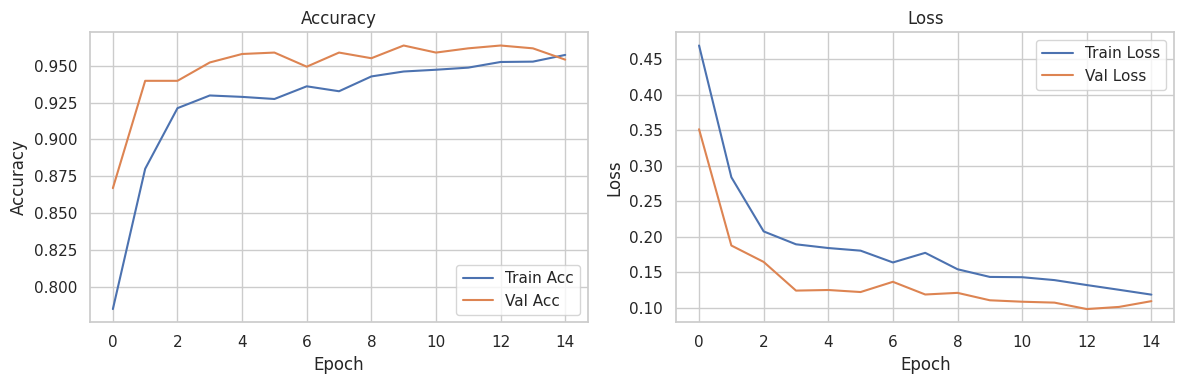

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 556ms/step


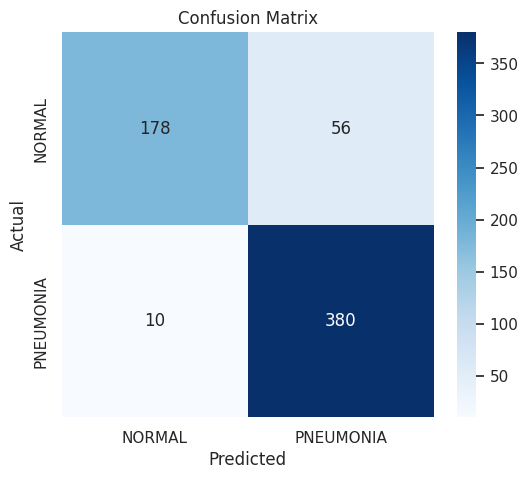

              precision    recall  f1-score   support

      NORMAL       0.95      0.76      0.84       234
   PNEUMONIA       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



In [29]:
# --- 3. METHODOLOGY: CNN for Pneumonia Classification ---

# --- 3.1 Data Preprocessing ---
img_size = (128, 128)  # smaller size for faster training
batch_size = 32

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Data augmentation + normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train/Validation/Test generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Print class indices
print("Class Indices:", train_gen.class_indices)  # {'NORMAL': 0, 'PNEUMONIA': 1}

# --- 3.2 Model Selection & Architecture ---
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='softmax')  # NORMAL vs PNEUMONIA
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- 3.3 Training Process ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,  # fewer epochs for speed; increase later if needed
    callbacks=callbacks,
    verbose=1
)

# --- 3.4 Training Visualization ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.show()

# --- 3.5 Evaluation on Test Set ---
preds = model.predict(test_gen, verbose=1)
y_true = test_gen.classes
y_pred = np.argmax(preds, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))
